In [ ]:
import os
import sys
import json
import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from glob import glob
from nilearn import plotting
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix

In [ ]:
task_label = 'tonecat'

project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
#bidsroot = os.path.join(project_dir,'data_bids')
bidsroot = os.path.join(project_dir,'data_bids_noIntendedFor')
deriv_dir = os.path.join(project_dir, 'derivatives', 'fmriprep_noSDC')

nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn')
if not os.path.exists(nilearn_dir):
        os.makedirs(nilearn_dir)

## Second-level analyses

Based on [nilearn documentation](https://nilearn.github.io/stable/auto_examples/05_glm_second_level/plot_thresholding.html#statistical-testing-of-a-second-level-analysis)

### Build the group-level design matrix

#### Read the `participants.tsv` file from the BIDS root directory

In [ ]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT01', 'sub-FLT16',  
               'sub-FLT19', 'sub-FLT20',
               'sub-FLT25', 'sub-FLT26',
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index, inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], ignore_index=True, inplace=True)

In [ ]:
print(participants_df)

In [ ]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])

In [ ]:
print(sub_list_mand)

In [ ]:
print(sub_list_nman)

#### Create design matrixes

In [ ]:
'''
# difference between groups
subjects_label = list(participants_df.participant_id)
groups_label = list(participants_df.group)
design_mat_groupdiff = pd.DataFrame({'group': groups_label,
                                    'intercept': np.zeros(len(subjects_label))})

design_mat_groupdiff['group'].loc[design_mat_groupdiff['group'] == 'Mandarin'] = 1
design_mat_groupdiff['group'].loc[design_mat_groupdiff['group'] == 'non-Mandarin'] = 0
design_mat_groupdiff = design_mat_groupdiff.astype('int')
print(design_mat_groupdiff)
'''
# difference between groups
subjects_label = list(participants_df.participant_id)
groups_label = list(participants_df.group)
design_mat_groupdiff = pd.DataFrame({'Mand': groups_label,
                                     'NMan': groups_label,
                                     #'intercept': np.ones(len(subjects_label))
                                    }
                                   )

design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'Mandarin'] = 1
design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'non-Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'non-Mandarin'] = 1
design_mat_groupdiff = design_mat_groupdiff.astype('int')
print(design_mat_groupdiff)

In [ ]:
# overall population (one-sample test)
n_subjects = len(participants_df)
design_matrix = pd.DataFrame([1] * n_subjects, columns=['intercept'])

In [30]:
'''
# single-group
design_mat_mand = pd.DataFrame([1] * len(sub_list_mand), columns=['intercept'])
design_mat_nman = pd.DataFrame([1] * len(sub_list_nman), columns=['intercept'])
'''

### Get files

In [ ]:
contrast_label = 'sound'
fwhm = 4.5
space_label = 'MNI152NLin2009cAsym'
l1_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 'level-1_fwhm-%.02f'%fwhm)
l1_fnames = sorted(glob(l1_dir+'/sub-*_space-%s/run-all/*%s_map-beta.nii.gz'%(space_label, contrast_label)))


In [ ]:
for sub_id in subjects_label:
    print(sorted(glob(l1_dir+'/%s_space-%s/run-all/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label))))

In [ ]:
l1_fnames_groupdiff = [sorted(glob(l1_dir+'/%s_space-%s/run-all/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in subjects_label]

#l1_fnames_mand = [sorted(glob(l1_dir+'/%s_space-%s/run-all/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in sub_list_mand]
#l1_fnames_nman = [sorted(glob(l1_dir+'/%s_space-%s/run-all/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in sub_list_nman]

### Mandarin-speaking group:

In [49]:
'''
second_level_model = SecondLevelModel().fit(l1_fnames_mand, design_matrix=design_mat_mand)
z_map = second_level_model.compute_contrast(output_type='z_score')
'''

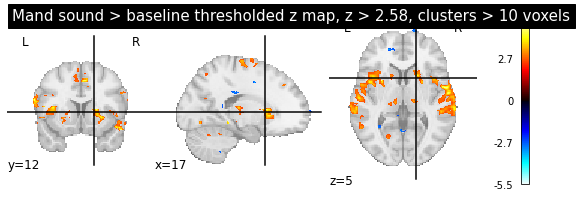

In [50]:
'''
from nilearn.image import threshold_img
threshold = 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))
'''

#### Using combined GLM, with contrast isolating Mandarin group

In [ ]:
second_level_model = SecondLevelModel().fit(l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)

#z_map = second_level_model.compute_contrast(second_level_contrast='group', output_type='z_score')
z_map = second_level_model.compute_contrast(second_level_contrast=[1, 0,], output_type='z_score')

In [ ]:
from nilearn.image import threshold_img
threshold = 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

In [ ]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=threshold,
                          colorbar=True)
plotting.show()

### Non-Mandarin speaking group:

In [47]:
'''
second_level_model = SecondLevelModel().fit(l1_fnames_nman, design_matrix=design_mat_nman)
z_map = second_level_model.compute_contrast(output_type='z_score')
'''

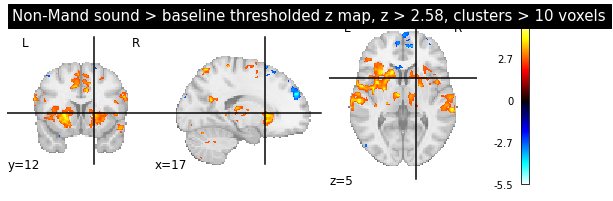

In [48]:
'''
from nilearn.image import threshold_img
threshold = 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Non-Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))
'''

#### Using combined GLM, with contrast isolating non-Mandarin-speaking group

In [54]:
second_level_model = SecondLevelModel().fit(l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)

#z_map = second_level_model.compute_contrast(second_level_contrast='group', output_type='z_score')
z_map = second_level_model.compute_contrast(second_level_contrast=[0, 1], output_type='z_score')

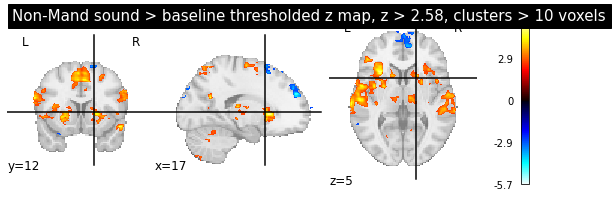

In [55]:
from nilearn.image import threshold_img
threshold = 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Non-Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

In [ ]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=threshold,
                          colorbar=True)
plotting.show()

### Group differences

In [56]:
second_level_model = SecondLevelModel().fit(l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)

#z_map = second_level_model.compute_contrast(second_level_contrast='group', output_type='z_score')
z_map = second_level_model.compute_contrast(second_level_contrast=[1, -1], output_type='z_score')

In [57]:
from nilearn.image import threshold_img
threshold = 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

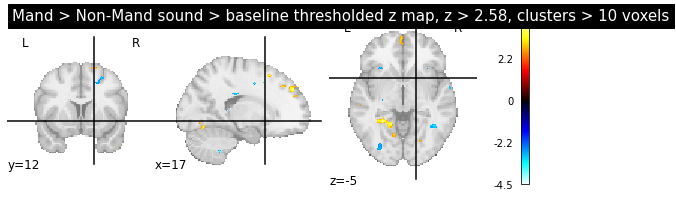

In [58]:
plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,-5], 
    title='Mand > Non-Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

In [ ]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=threshold,
                          colorbar=True)
plotting.show()

#### And try the reverse, just to confirm they are equal but opposite....

In [59]:
second_level_model = SecondLevelModel().fit(l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)

#z_map = second_level_model.compute_contrast(second_level_contrast='group', output_type='z_score')
z_map = second_level_model.compute_contrast(second_level_contrast=[-1, 1], output_type='z_score')

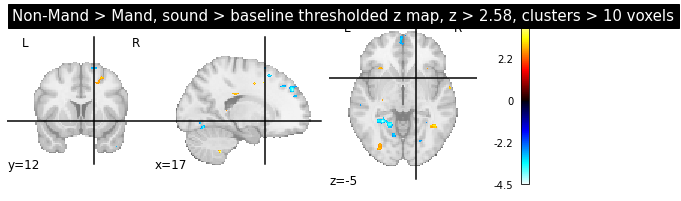

In [60]:
from nilearn.image import threshold_img
threshold = 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)
plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,-5], 
    title='Non-Mand > Mand, %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

### Permutation tests

In [43]:
from nilearn.glm.second_level import non_parametric_inference

In [ ]:
contrast_map_filenames = 

In [ ]:
log_pvals_permuted_ols_unmasked = \
    non_parametric_inference(contrast_map_filenames,
                             design_matrix=design_mat_groupdiff,
                             n_perm=1000,
                             n_jobs=1)

### All participants

In [ ]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel().fit(l1_fnames, design_matrix=design_matrix)

z_map = second_level_model.compute_contrast(output_type='z_score')

from nilearn import plotting
display = plotting.plot_stat_map(z_map, title='Raw z map - %s > baseline'%contrast_label)

In [ ]:
from nilearn.image import threshold_img
threshold = 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='%s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

In [ ]:
from nilearn.glm import threshold_stats_img
fpr_alpha = .01
cthresh = 10
thresholded_map1, \
    threshold1 = threshold_stats_img(
                                    z_map,
                                    alpha=fpr_alpha,
                                    height_control='fpr',
                                    cluster_threshold=cthresh,
                                    two_sided=True,
                                    )
plotting.plot_stat_map(
    thresholded_map1, cut_coords=display.cut_coords, threshold=threshold1,
    title='%s > baseline thresholded z map, fpr <%.03f, clusters > %d voxels'%(contrast_label, fpr_alpha, cthresh))
print(threshold1)

In [ ]:
thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr')
print('The FDR=.05 threshold is %.3g' % threshold2)

plotting.plot_stat_map(thresholded_map2, cut_coords=display.cut_coords,
                       title='%s > baseline thresholded z map, expected fdr = .05'%contrast_label,
                       threshold=threshold2)

### Surface plots

In [114]:
from nilearn import datasets, surface

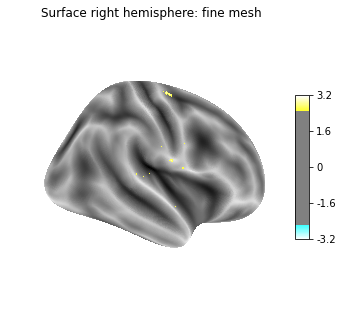

In [115]:
big_fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
big_texture = surface.vol_to_surf(z_map, big_fsaverage.pial_right)

plotting.plot_surf_stat_map(big_fsaverage.infl_right,
                            big_texture, hemi='right', colorbar=True,
                            title='Surface right hemisphere: fine mesh',
                            threshold=2.58, bg_map=big_fsaverage.sulc_right)
plotting.show()

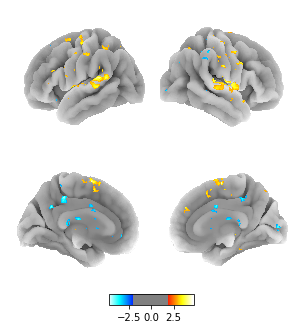

In [119]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=1.96, #2.58,
                          colorbar=True)
plotting.show()

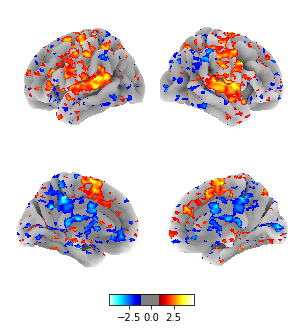

In [117]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=1, #2.58,
                          colorbar=True)
plotting.show()